### 1. Importing packages

In [ ]:
!pip install gurobipy

In [ ]:
import pandas as pd
from scipy.spatial.distance import squareform, pdist
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import gurobipy as gp
from gurobipy import GRB

### 2. Loading dataset

In [ ]:
# reading data and creating distance matrix
def prepare_tsp_data(filename):
    df = pd.read_csv(filename)
    D = squareform(pdist(df))
    return df, D

In [ ]:
# plotting cities and tour
def plot_tsp(df, tour=None, open_tour=False):
    plt.figure(figsize=(10,10))
    plt.scatter(df.x, df.y)
    if tour:
        for i, j in tour:
            x1 = df.loc[i]['x']
            x2 = df.loc[j]['x']
            y1 = df.loc[i]['y']
            y2 = df.loc[j]['y']
            plt.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['id'])
            plt.text(df.loc[j]['x'], df.loc[j]['y'], df.loc[j]['id'])
            x = [x1, x2]
            y = [y1, y2]
            if j == 0:
                if not open_tour:
                    plt.plot(x, y, 'r')
            else:
                plt.plot(x, y, 'b')

In [ ]:
df, D = prepare_tsp_data('usa35.csv')

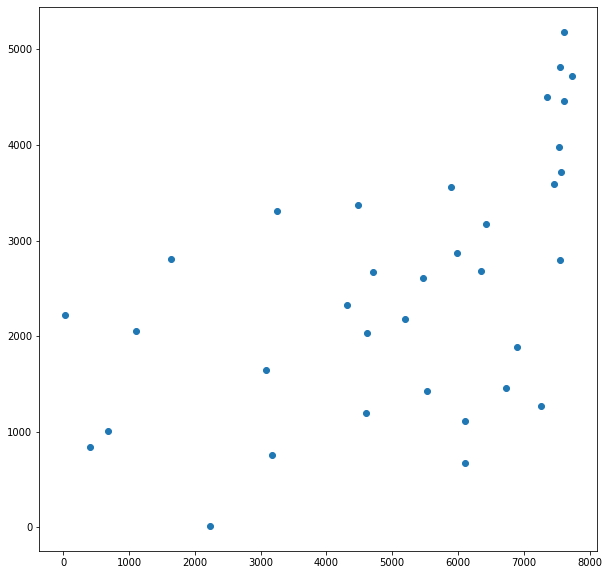

In [ ]:
plot_tsp(df)

### 3. MTZ formulation

In [ ]:
# solving tsp
def solve_tsp(df, D):
    try:
        N = df.shape[0]

        # model
        tsp_model = gp.Model('tsp')

        # variables
        x, u = {}, {}
        for i in range(N):
            u[i] = tsp_model.addVar(lb=0, ub=N-1, vtype=GRB.CONTINUOUS, name=f'u{i}')
            for j in range(N):
                x[i,j] = tsp_model.addVar(vtype=GRB.BINARY, name=f'x{i,j}')
        
        # objective
        obj = gp.quicksum(x[i,j] * D[i,j] for j in range(N) for i in range(N))
        tsp_model.setObjective(obj, GRB.MINIMIZE)
        
        # constraints
        # no self-connection
        for i in range(N):
            tsp_model.addConstr(x[i,i] == 0)

        # unique incoming edge
        for j in range(N):
            tsp_model.addConstr(gp.quicksum(x[i,j] for i in range(N)) == 1)

        # unique outgoing edge
        for i in range(N):
            tsp_model.addConstr(gp.quicksum(x[i,j] for j in range(N)) == 1)

        # preventing sub-tours
        for i in range(N):
            for j in range(N):
                if j != 0:
                    tsp_model.addConstr(u[j] >= u[i] + 1 - (2 * N) * (1 - x[i,j]))
        
        # optimizing model
        tsp_model.optimize()

        print('-----------------------------')
        print(f'Min. Dist = {tsp_model.objVal}')
        tour = [(i,j) for i in range(N) for j in range(N) if x[i,j].x == 1]
        plot_tsp(df, tour)
    except gp.GurobiError as e:
        print(f'Error code {e.errno} : {e}')

Restricted license - for non-production use only - expires 2023-10-25
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 1295 rows, 1260 columns and 5987 nonzeros
Model fingerprint: 0x2da8c234
Variable types: 35 continuous, 1225 integer (1225 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [2e+02, 8e+03]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 7e+01]
Presolve removed 69 rows and 36 columns
Presolve time: 0.02s
Presolved: 1226 rows, 1224 columns, 5814 nonzeros
Variable types: 34 continuous, 1190 integer (1190 binary)
Found heuristic solution: objective 94573.641349

Root relaxation: objective 2.383162e+04, 111 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 23831.6235   

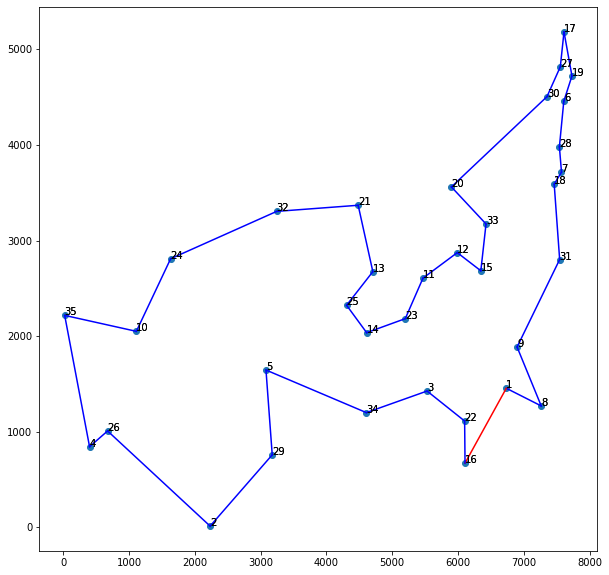

In [ ]:
solve_tsp(df, D)